# TSP Data Extraction

First we download the SATCAT catalogue and the TLE data from https://celestrak.com/. In this example, we will take the debris data of the irdium-33 satellite from the collision with cosmos-2251.

In [1]:
import urllib.request
import os

def download(url, file_name):
    
    if not os.path.exists(file_name):
        print("downloading data from " + str(url))
        with open(file_name, "wb") as file:
            response = urllib.request.urlopen(url)
            file.write(response.read())
    
PATH_TO_SATCAT = "data/satcat.txt"
PATH_TO_DEBRIS_TLE = "data/iridium-33-debris.txt"

if not os.path.exists("data"):
    print("Creating data folder")
    os.makedirs("data")
    
download("https://celestrak.com/pub/satcat.txt", PATH_TO_SATCAT)
download("https://www.celestrak.com/NORAD/elements/iridium-33-debris.txt", PATH_TO_DEBRIS_TLE)

Creating data folder
downloading data from https://celestrak.com/pub/satcat.txt
downloading data from https://www.celestrak.com/NORAD/elements/iridium-33-debris.txt


The function <code> compute_static_TSP_data </code> computes an instance of a static city selection travelling salesman problem based on the TLE data and SATCAT catalogue that is passed to the function. For the compuation of the edges, the three impulsive approximation from the pykep module is used. For the preferences, the radarA value of the SATCAT catalogue has been chosen. A dictionary with keys 'A' (distance matrix), 'P' preference values and 'ids' for the corresponding debris ids is returned.

In [2]:
from preprocessing import data_processing

static_data = data_processing.compute_static_TSP_data(PATH_TO_SATCAT, PATH_TO_DEBRIS_TLE)

Preprocessing indices for three impulse approximation



Computing cost approximations for static TSP


The resulting distance matrix:

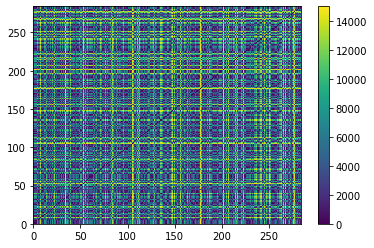

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(static_data['A'])
plt.colorbar()
plt.show()

In [4]:
nDebris = static_data['P'].shape[0]
for i in range(0, nDebris, 35):
    print(f"Debris {i} in the CS-TSP has the catalog number {static_data['ids'][i]} and radar area {static_data['P'][i]}")

Debris 0 in the CS-TSP has the catalog number 1997-051C and radar area 2.519
Debris 35 in the CS-TSP has the catalog number 1997-051BV and radar area 0.04
Debris 70 in the CS-TSP has the catalog number 1997-051EW and radar area 0.0057
Debris 105 in the CS-TSP has the catalog number 1997-051JZ and radar area 0.0147
Debris 140 in the CS-TSP has the catalog number 1997-051PA and radar area 0.0109
Debris 175 in the CS-TSP has the catalog number 1997-051SC and radar area 0.0122
Debris 210 in the CS-TSP has the catalog number 1997-051VN and radar area 0.0139
Debris 245 in the CS-TSP has the catalog number 1997-051YV and radar area 0.0032
Debris 280 in the CS-TSP has the catalog number 1997-051ABG and radar area 0.0041


Now, we will generate data for the dynamic city selection TSP. To do so, we need to pass the timepoints in which a transfer is allowed. We can use the convenience funktion <code> compute_epochs </code> to compute an array of epochs. The function takes three arguments: the starting day (as julian date from 2000), the number of epochs and the distance of days between the sampling.

In [5]:
# 7350 julian date 2000: 15.2.2019
# 52 time points, every week one, total period of one year
epochs = data_processing.compute_epochs(7350,52,7)
dynamic_data = data_processing.compute_dynamic_TSP_data(PATH_TO_SATCAT, PATH_TO_DEBRIS_TLE, epochs)

Preprocessing indices for dynamic three impulse approximation



Computing cost approximations for dynamic TSP


We will plot the costs of transferring from debris piece 2 to debris piece 3 over time

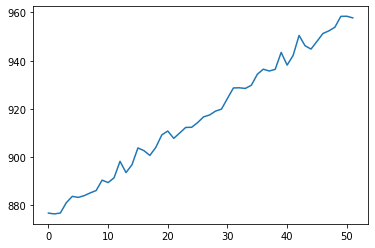

In [6]:
plt.plot(dynamic_data['A'][2,3,:])
plt.show()

One approach in this thesis was to use linear regression to reduce the number of parameters to two for each pair of debris pieces. we can use the convenience function <code>compute_regression_for_matrix</code> for obtaining the parameters.

Computing regression parameters


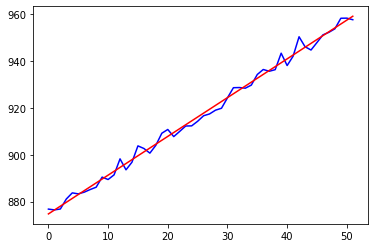

In [7]:
regr_params = data_processing.compute_regression_for_matrix(dynamic_data['A'])

b = regr_params[2,3,0]
m = regr_params[2,3,1]
nEpochs = dynamic_data['A'].shape[2]

y_hat = [b + m*i for i in range(nEpochs)]

plt.plot(dynamic_data['A'][2,3,:], 'b')
plt.plot(y_hat, 'r')

plt.show()

# Optimization

For the mixed integer programs, we will use the optimization functions from the python files mips_static and mips_dynamic. We will begin with the static problem formulation. The supported subtour elimination constraints are F1, F3, T1, T2, seq. As an input, these functions expect that a center is at 0, we will put a leading zero to our data to find a hamiltonian path of the space debris.

In [8]:
from optimization import mips_static

# reduce input size for faster solution
A = static_data['A'][:50,:50]
P = static_data['P'][:50]

A, P = data_processing.add_leading_zero_static(A, P)

res = mips_static.TSP_static(A, P, budget = 1000, SEC_TYPE = "F1")

Academic license - for non-commercial use only
Optimize a model with 2704 rows, 5151 columns and 17903 nonzeros
Variable types: 2550 continuous, 2601 integer (2601 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [9e-03, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 0.2293000
Presolve removed 2154 rows and 4274 columns
Presolve time: 0.06s
Presolved: 550 rows, 877 columns, 3057 nonzeros
Variable types: 418 continuous, 459 integer (459 binary)

Root relaxation: objective 6.458497e+00, 597 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.45850    0   39    0.22930    6.45850  2717%     -    0s
     0     0    6.34821    0   50    0.22930    6.34821  2669%     -    0s
     0     0    6.32940    0   50    0.22930    6.32940  2660%     -    0s
H   

In [9]:
tour = mips_static.get_static_tour(res)


Final: 5.186

Node included:
0 1 2 3 4 5 18 26 31 44 
Edges used:
0-5, 1-4, 2-31, 3-44, 4-26, 5-18, 18-2, 26-0, 31-3, 44-1, 

We can plot the result by calling the module plot. The plot will show the 

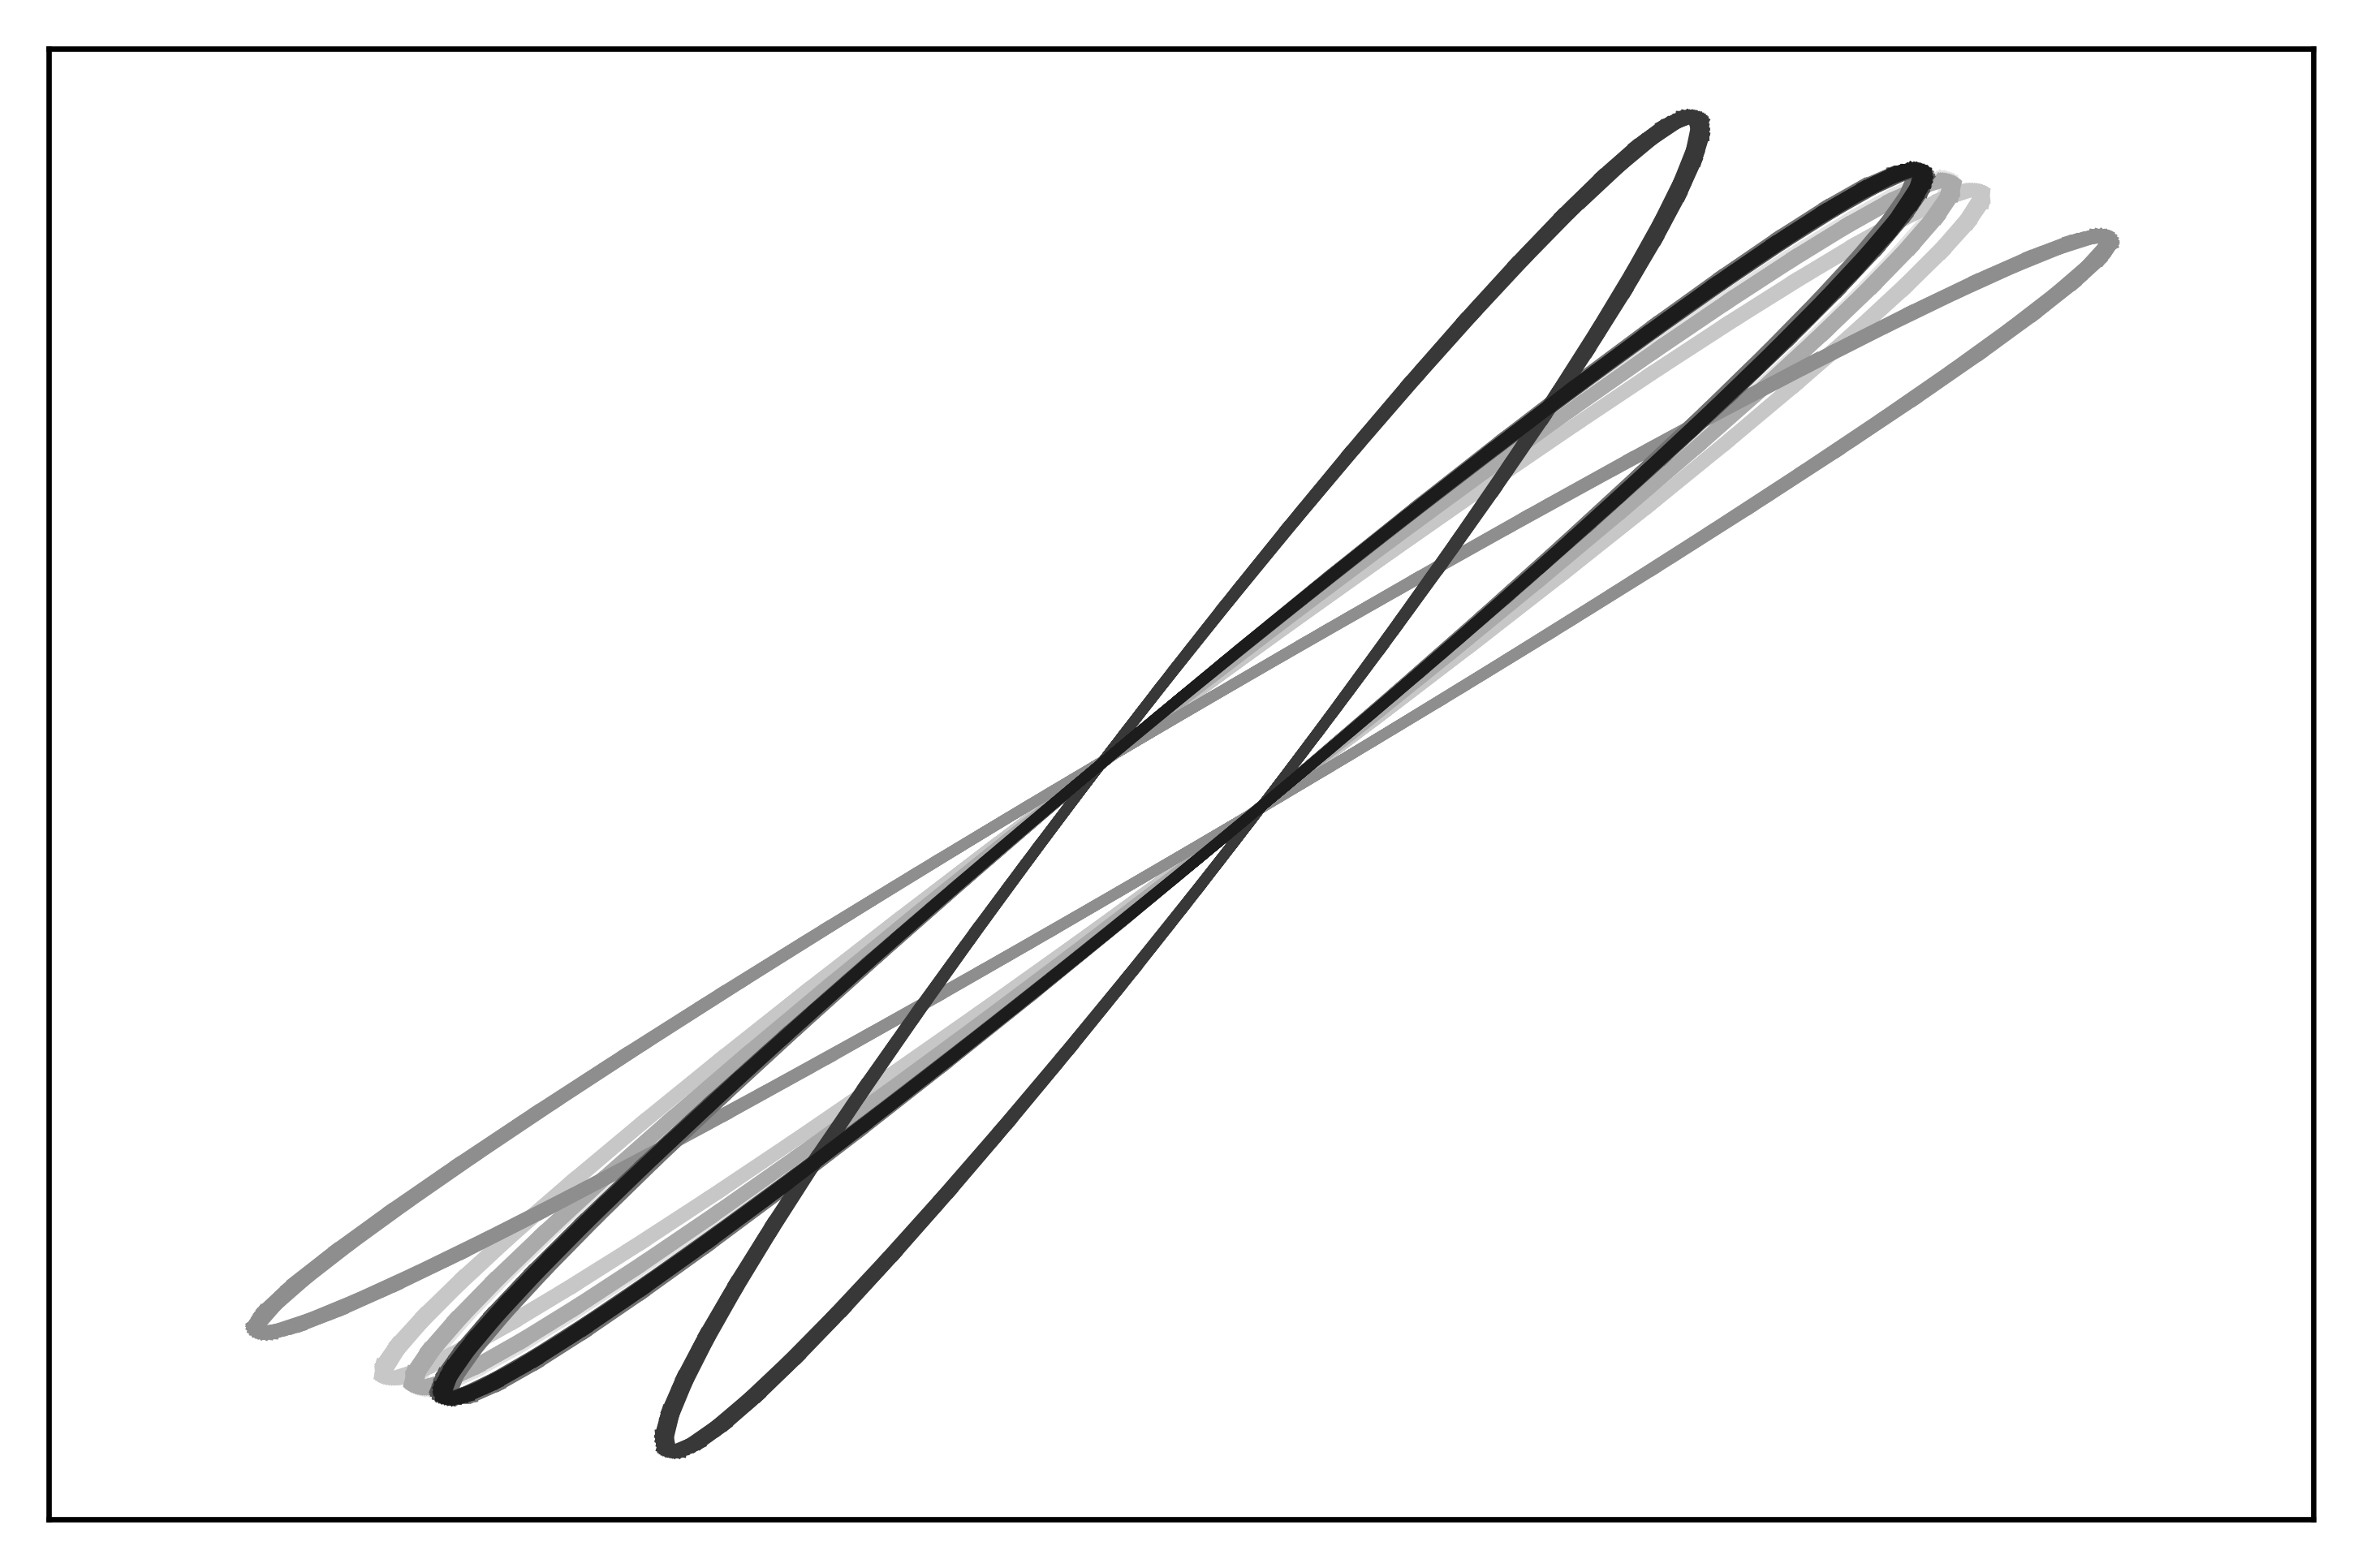

In [10]:
from visualization import plot

# order tour
tour = mips_static.order_cycle_edges(tour)

# remove leading zero
indices_ordered = [t[0]-1 for t in tour[1:]]

line1_list = [static_data['line1'][i] for i in indices_ordered]
line2_list = [static_data['line2'][i] for i in indices_ordered]

tle_list = list(zip(line1_list, line2_list))

plot.plot_orbits_2d(tle_list, 2020, 2, from_day = 15, until_day = 16)

Now we will continue with the dynamic problem formulation. The supported subtour elimination constraints are DT1, DF1, DF2 and based on static variants: F1, F3, T1, T2, seq

In [11]:
from optimization import mips_dynamic
import numpy as np

# reduce input size for faster solution
A = dynamic_data['A'][:50, :50, :]
P = dynamic_data['P'][:50]
params = regr_params[:50, :50, :]

A, P, params = data_processing.add_leading_zero_dynamic(A, P, params)

In [12]:
res = mips_dynamic.TSP_dynamic(A, P, transfer_duration = 1, budget = 1000, regr_params = params, SEC_TYPE = "DT1")

Optimize a model with 153 rows, 132651 columns and 647752 nonzeros
Variable types: 0 continuous, 132651 integer (132651 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [9e-03, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 21 rows and 119936 columns
Presolve time: 0.38s
Presolved: 132 rows, 12715 columns, 62973 nonzeros
Found heuristic solution: objective 0.0850000
Variable types: 0 continuous, 12715 integer (12715 binary)

Root relaxation: objective 6.867961e+00, 281 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.86796    0   64    0.08500    6.86796  7980%     -    0s
H    0     0                       2.5190000    6.86796   173%     -    0s
H    0     0                       3.9629000    6.86796  73.3%     -   

In [13]:
tour_times = mips_dynamic.get_times_DT1(res)


Final: 4.5866

Node included:
0 1 3 5 11 21 30 35 39 48 
Edges used:
0-5 at 0
5-39 at 1
39-11 at 2
11-3 at 45
3-35 at 46
35-21 at 47
21-48 at 48
48-30 at 49
30-1 at 50
1-0 at 51


We can also apply a genetic algorithm for a solution.

In [14]:
from optimization import genetic

gen = genetic.GA(A, P, transfer_time = 1, budget = 1000)

There are various parameters that can be adjusted

In [15]:
# population size for every execution of genetic algorithm
gen.set_parameter("population size", 500)

# probability for a crossover
gen.set_parameter("crossover rate", 0.3)

# ratio of individuals replaced in each iteration
gen.set_parameter("dying rate", 0.6)

# probability of random survival
gen.set_parameter("survival rate", 0.1)

# number iterations for each genetic algorithm
gen.set_parameter("nIterations", 200)

# genetic algorithm runs nFittest times
# each time the fittest individual will be returned
# for creating a final population and application of
# the genetic algorithm
gen.set_parameter("nFittest", 40)

Finally, run the genetic algorithm and print the solution

In [16]:
ind = gen.run()
print(ind)


edge 0-1 at time 0
edge 1-3 at time 1
edge 3-35 at time 2
edge 35-30 at time 3
edge 30-48 at time 4
edge 48-21 at time 5
edge 21-0 at time 6


We can plot the evolution of the fittest individual for every iteration.

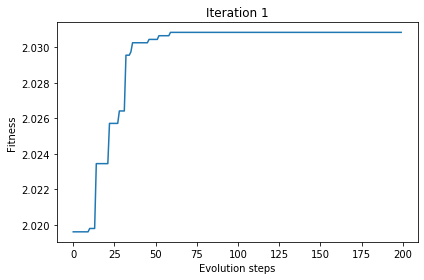

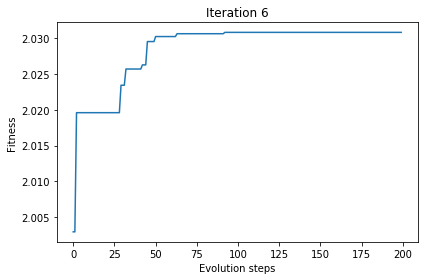

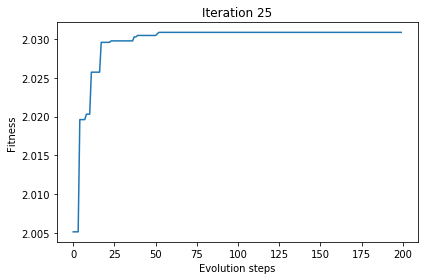

0

In [17]:
gen.plot(["Iteration 1", "Iteration 6", "Iteration 25"])